Afisare date initiale

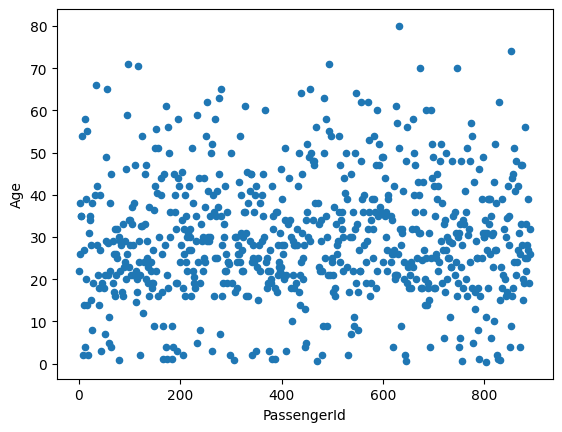

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('train.csv')
df.plot(kind = 'scatter', x = 'PassengerId', y = 'Age')
plt.show()

**Cerinta 1:** Folositi interquartile range pentru a identifica si elimina outlier-ele. O valoare
este considerată outlier dacă este mai mică decât Q1 - 1.5IQR sau mai mare decât Q3 + 1.5IQR,
unde Q1 si Q3 sunt primul si al treilea percentile, iar IQR este diferent, a dintre Q3 si Q1. Dacă
luăm de exemplu variabila "age" din setul de date Titanic, putem calcula Q1 si Q3, apoi IQR.
Valorile care sunt în afara intervalului Q1 - 1.5IQR si Q3 + 1.5IQR pot fi considerate outlier-e
si eliminate.

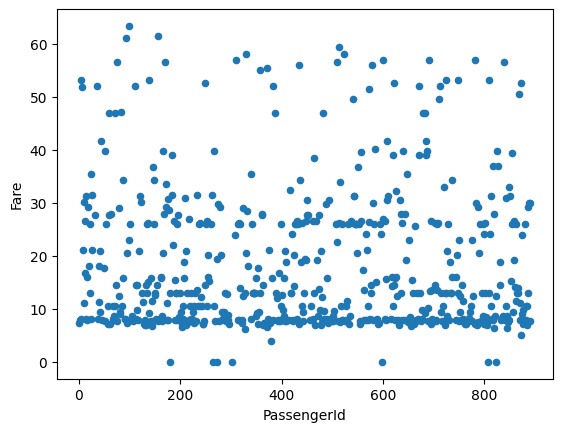

In [63]:
############################################
            # Outlieri varsta #
############################################
age = df['Age']

# elimina coloanele pentru care nu exita datele legate de varsta
age = age.dropna()

# calculeaza primul percentile
ageQ1 = np.percentile(age, 25)
# calculeaza al treilea percentile
ageQ3 = np.percentile(age, 75)
# interquartile range
ageIQR = ageQ3 - ageQ1

# valoarea sub care se afla outlieri
ageMinValue = ageQ1 - 1.5*ageIQR
# valoarea peste care se afla outlieri
ageMaxValue = ageQ3 + 1.5*ageIQR

# eliminare outlieri
df_filtrat_varsta = df[(df['Age'] >= ageMinValue) & (df['Age'] <= ageMaxValue)]

############################################
            # Outlieri pret #
############################################

fare = df_filtrat_varsta['Fare']

# elimina coloanele pentru care nu exita datele legate de varsta
fare = fare.dropna()

# calculeaza primul percentile
fareQ1 = np.percentile(age, 25)
# calculeaza al treilea percentile
fareQ3 = np.percentile(age, 75)
# interquartile range
fareIQR = fareQ3 - fareQ1

# valoarea sub care se afla outlieri
fareMinValue = fareQ1 - 1.5*fareIQR
# valoarea peste care se afla outlieri
fareMaxValue = fareQ3 + 1.5*fareIQR

# eliminare outlieri
df_filtrat_pret = df_filtrat_varsta[(df_filtrat_varsta['Fare'] >= fareMinValue) & (df_filtrat_varsta['Fare'] <= fareMaxValue)]

#grafic cu valori eliminate
df_filtrat_pret.plot(kind = 'scatter', x = 'PassengerId', y = 'Fare')
plt.show()

Calculati Z-score pentru fiecare observatie si eliminati valorile care au un Z-score
absolut mai mare decât un anumit prag (de exemplu, 3 sau 4). Z-score reprezintă numărul de
deviatii standard fata de media setului de date. Pentru aceeasi variabilă "age", putem calcula Z-score pentru fiecare vârstă si să eliminăm valorile care au un Z-score mai mare de, să zicem, 3. Valorile cu un Z-score mai mare de 3 ar putea fi considerate outlier-e.